# Basic examples

In this notebook we will show how to compute Lagrangian "lognormal" mocks, and apply a cutsky geometry.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

from mockfactory import LagrangianLinearMock, utils, setup_logging
from cosmoprimo.fiducial import DESI

# Set up logging
setup_logging()
z = 1.
# Load DESI fiducial cosmology
cosmo = DESI()
power = cosmo.get_fourier().pk_interpolator().to_1d(z=z)

In [2]:
dist = cosmo.comoving_radial_distance(z)
f = cosmo.sigma8_z(z=z,of='theta_cb')/cosmo.sigma8_z(z=z,of='delta_cb') # growth rate
bias, nbar, nmesh, size = 2.0, 1e-3, 256, 1000.
boxcenter = [dist, 0, 0]
mock = LagrangianLinearMock(power, nmesh=nmesh, boxsize=size, boxcenter=boxcenter, seed=42, unitary_amplitude=False)
# this is Lagrangian bias, Eulerian bias - 1
mock.set_real_delta_field(bias=bias-1)
mock.set_analytic_selection_function(nbar=nbar)
mock.poisson_sample(seed=43)
mock.set_rsd(f=f, los=None)
data = mock.to_catalog()

# We've got data, now turn to randoms
from mockfactory.make_survey import RandomBoxCatalog
randoms = RandomBoxCatalog(nbar=4.*nbar, boxsize=size, seed=44)

[000004.97]  11-13 23:25  LagrangianLinearMock         INFO     White noise generated
[000009.03]  11-13 23:25  LagrangianLinearMock         INFO     Poisson sampling done, total number of objects is 999642
[000010.97]  11-13 23:25  LagrangianLinearMock         INFO     Catalog produced. Assigning in cell shift.


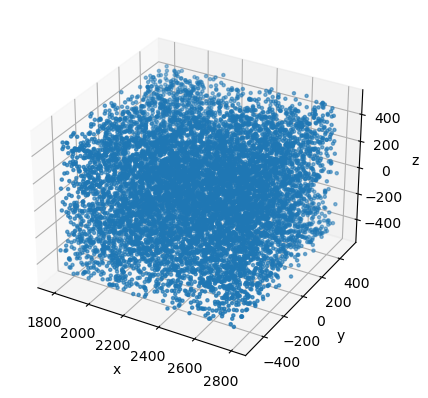

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*data['Position'][::100].T, marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

Cut 4 catalogs.


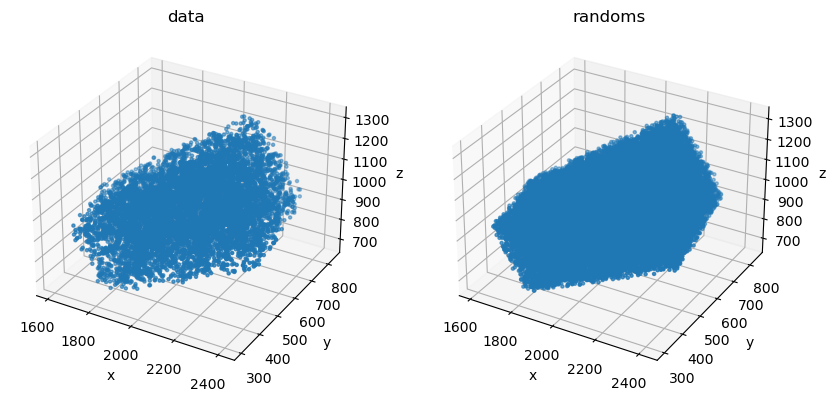

In [4]:
# Let us cut the above box to some geometry
drange = [dist - size/3., dist + size/3.]
rarange = [10, 20]
decrange = [20, 30]

# noutput = None will cut as many catalogs as possible
data_cutsky = data.cutsky(drange=drange,rarange=rarange,decrange=decrange,noutput=None)
print('Cut {:d} catalogs.'.format(len(data_cutsky)))
data_cutsky = data_cutsky[0]
randoms_cutsky = randoms.cutsky(drange=drange,rarange=rarange,decrange=decrange)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(121, projection='3d', title='data')
ax.scatter(*data_cutsky['Position'][::10].T, marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax = fig.add_subplot(122, projection='3d', title='randoms')
ax.scatter(*randoms_cutsky['Position'][::10].T, marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

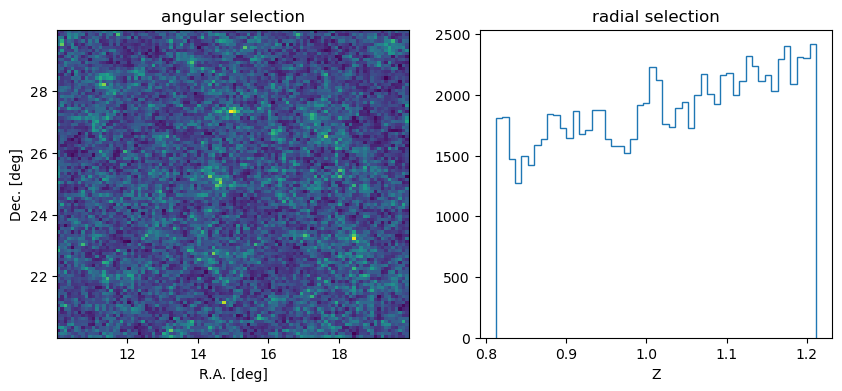

In [5]:
# Let's look at the angular and radial selection function

data_cutsky['Distance'], data_cutsky['RA'], data_cutsky['DEC'] = utils.cartesian_to_sky(data_cutsky['Position'])
from mockfactory.make_survey import DistanceToRedshift
distance_to_redshift = DistanceToRedshift(distance=cosmo.comoving_radial_distance)
data_cutsky['Z'] = distance_to_redshift(data_cutsky['Distance'])

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121, title='angular selection')
ax.hist2d(data_cutsky['RA'], data_cutsky['DEC'], bins=100)
ax.set_xlabel('R.A. [deg]')
ax.set_ylabel('Dec. [deg]')
ax = fig.add_subplot(122, title='radial selection')
ax.hist(data_cutsky['Z'], histtype='step', bins=50)
ax.set_xlabel('Z')
plt.show()

41.6953 % of objects will be selected


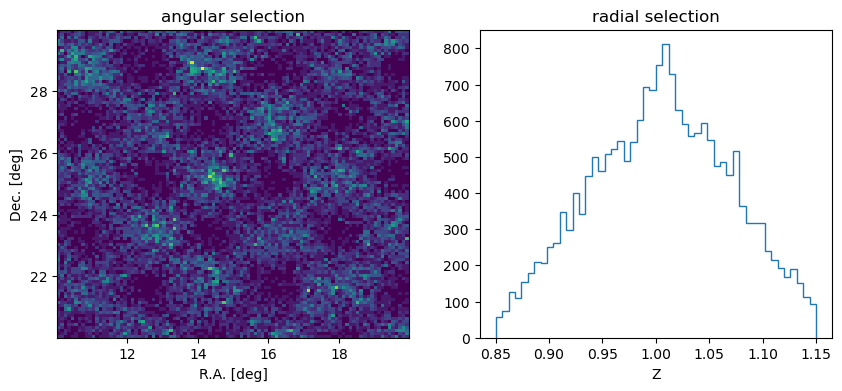

In [6]:
# Let us apply some redshift cuts
from mockfactory.make_survey import TabulatedRadialMask, HealpixAngularMask

z = np.linspace(0.85, 1.15, 51)
nbar = np.exp(-200.*(z - 1.0)**2/2.)
mask_radial = TabulatedRadialMask(z=z, nbar=nbar)
print('{:.4f} % of objects will be selected'.format(100.*mask_radial.integral(data_cutsky['Z'])))
# And some angular cuts, e.g. healpix map
import healpy
nside = 256
theta, phi = healpy.pix2ang(nside, np.arange(healpy.nside2npix(nside)), nest=False, lonlat=False)
nbar = 1. + np.cos(100.*theta) * np.cos(100.*phi)
nbar /= nbar.max()
mask_angular = HealpixAngularMask(nbar, nest=False)
mask = mask_radial(data_cutsky['Z'], seed=84) & mask_angular(data_cutsky['RA'], data_cutsky['DEC'], seed=85)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121, title='angular selection')
ax.hist2d(data_cutsky['RA'][mask], data_cutsky['DEC'][mask], bins=100)
ax.set_xlabel('R.A. [deg]')
ax.set_ylabel('Dec. [deg]')
ax = fig.add_subplot(122, title='radial selection')
ax.hist(data_cutsky['Z'][mask], histtype='step', bins=50)
ax.set_xlabel('Z')
plt.show()

In [7]:
# Export to e.g. fits
base_dir = '_tests'
fn = os.path.join(base_dir,'tmp.fits')
data_cutsky[mask].save_fits(fn)
# Reload
from mockfactory.make_survey import CutskyCatalog
data_cutsky = CutskyCatalog.load_fits(fn)
print(data_cutsky.columns())

[000015.63]  11-13 23:25  FitsFile                     INFO     Saving to _tests/tmp.fits.
[000015.65]  11-13 23:25  FitsFile                     INFO     Loading _tests/tmp.fits.
['Distance', 'Position', 'RA', 'DEC', 'Z', 'Displacement']


In [8]:
# You can also benefit from MPI, let's write a script

In [9]:
%%file '_tests/script.py'

import os

import numpy as np
from matplotlib import pyplot as plt

from mockfactory import LagrangianLinearMock, utils, setup_logging
from cosmoprimo.fiducial import DESI

# Set up logging
setup_logging()
z = 1.
# Loading DESI fiducial cosmology
cosmo = DESI()
power = cosmo.get_fourier().pk_interpolator().to_1d(z=z)

dist = cosmo.comoving_radial_distance(z)
f = cosmo.sigma8_z(z=z,of='theta_cb')/cosmo.sigma8_z(z=z,of='delta_cb') # growth rate
bias, nbar, nmesh, size = 2.0, 1e-3, 256, 1000.
boxcenter = [dist, 0, 0]
mock = LagrangianLinearMock(power, nmesh=nmesh, boxsize=size, boxcenter=boxcenter, seed=42, unitary_amplitude=False)
# this is Lagrangian bias, Eulerian bias - 1
mock.set_real_delta_field(bias=bias-1)
mock.set_analytic_selection_function(nbar=nbar)
mock.poisson_sample(seed=43)
mock.set_rsd(f=f, los=None)
data = mock.to_catalog()

# We've got data, now turn to randoms
from mockfactory.make_survey import RandomBoxCatalog
randoms = RandomBoxCatalog(nbar=4.*nbar, boxsize=size, seed=44)

# Let us cut the above box to some geometry
drange = [dist - size/3., dist + size/3.]
rarange = [10, 20]
decrange = [20, 30]

data = data.cutsky(drange=drange,rarange=rarange,decrange=decrange)
randoms = randoms.cutsky(drange=drange,rarange=rarange,decrange=decrange)

from mockfactory.make_survey import DistanceToRedshift
distance_to_redshift = DistanceToRedshift(distance=cosmo.comoving_radial_distance)

for catalog in [data, randoms]:
    catalog['Distance'], catalog['RA'], catalog['DEC'] = utils.cartesian_to_sky(catalog.position)
    catalog['Z'] = distance_to_redshift(catalog['Distance'])

# Let us apply some redshift cuts
from mockfactory.make_survey import TabulatedRadialMask

z = np.linspace(0.85, 1.15, 51)
nbar = np.exp(-200.*(z - 1.0)**2/2.)
mask_radial = TabulatedRadialMask(z=z, nbar=nbar)

base_dir = '_tests'

fn = os.path.join(base_dir, 'data.fits')
mask = mask_radial(data['Z'], seed=84)
data[mask].save_fits(fn)

fn = os.path.join(base_dir, 'randoms.fits')
mask = mask_radial(randoms['Z'], seed=85)
randoms[mask].save_fits(fn)

Overwriting _tests/script.py


In [10]:
%%bash
export OMP_NUM_THREADS=1
mpiexec -n 2 python _tests/script.py

[000003.87]  11-13 23:25  LagrangianLinearMock         INFO     White noise generated
[000016.85]  11-13 23:26  LagrangianLinearMock         INFO     Poisson sampling done, total number of objects is 999642
[000018.53]  11-13 23:26  LagrangianLinearMock         INFO     Catalog produced. Assigning in cell shift.
[000020.59]  11-13 23:26  FitsFile                     INFO     Saving to _tests/data.fits.
[000020.64]  11-13 23:26  FitsFile                     INFO     Saving to _tests/randoms.fits.


/local/home/adematti/anaconda3/envs/cosmopipe-dev/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/local/home/adematti/anaconda3/envs/cosmopipe-dev/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [11]:
!ls -l _tests

total 7572
-rw-r----- 1 adematti dapna48 1543680 nov.  13 23:26 data.fits
-rw-r----- 1 adematti dapna48 4642560 nov.  13 23:26 randoms.fits
-rw-r----- 1 adematti dapna48    2061 nov.  13 23:25 script.py
-rw-r----- 1 adematti dapna48 1558080 nov.  13 23:25 tmp.fits
